<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Statistics with Baseball Data: Priors and Posteriors


---

To review the general setup for Bayesian modeling, we have:

$$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)}{P(\;data\;)} P\left(\;model\;\right)\ .$$

This can also be written as:

$$posterior \propto likelihood \cdot prior$$

where the posterior is an update of our prior belief, given the data observed.


## Review: the Beta distribution

---

[The Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is the appropriate prior distribution for modeling Bernoulli and/or Binomial processes (occurrences of successes or failures, etc.). It is a model of the random behavior of data related to percentages, rates, proportions, etc.

The Beta distribution takes two parameters: $Beta(\alpha,\beta)$

The $\alpha$ or **alpha** parameter can be thought of as the number of `successes + 1`

The $\beta$ or **beta** parameter can be thought of as the number of `failures + 1`

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/650px-Beta_distribution_pdf.svg.png" alt="betapdf" style="width: 400px;"/>

## Review: the Beta as a "conjugate prior"

---

The beta distribution is a **conjugate prior** for the binomial (and the beta) distributions. What does this mean?

Take the calculation of the posterior distribution with a binomial likelihood function (any binary outcome data):

$$\text{beta posterior} \propto \text{binomial likelihood} \cdot \text{beta prior}$$

**The Beta distribution being a "conjugate prior" of the Binomial likelihood guarantees that the posterior distribution will also be a Beta distribution.** 
符合beta分布的前验 乘以 二元伯努利 得出 符合beta分布的后验

> **Note:** Conjugate priors are extremely useful for calculating posteriors directly. Unfortunately, in many modeling scenarios we do not have the convenience of a conjugate prior. This is where methods like Markov Chain Monte Carlo (MCMC) will come into play down the line.

## Bayesian analysis of batting averages

---

Load in the simple batting avergage data for players below. There are just four fields in the dataset: the player's name, their times at bat, their hits, and their batting average.

> **Note:** [This section of the lab is a partial replication of this exercise in R, if you're interested without the "empirical Bayes" part.](https://www.r-bloggers.com/understanding-empirical-bayes-estimation-using-baseball-statistics/) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.stats import beta

In [3]:
hits = pd.read_csv('../../../../resource-datasets/baseball_hits/career_hits.csv')

how many time played = n
hit ball = k
p = k / n 
what is the peak location and the shape of it
form the prior believe
what's the genral success rate in baseball
each player need to has two numbers, k/n and MAP

### 1. Find the top and bottom 3 hitters according to their average.

What is wrong with using the average to find the 3 best and 3 worst hitters?

In [18]:
hits[['name','average']].sort_values(by = 'average', ascending=False).head()

,name,average
5853,John Mohardt,1.0
9303,Al Wright,1.0
359,Jeff Banister,1.0
5440,Sparrow McCaffrey,1.0
1126,C. B. Burns,1.0


In [9]:
hits.sort_values(by = "average")[0:3]

,name,hits,at_bat,average
1494,Larry Ciaffone,0,5,0.0
7303,Jay Rogers,0,8,0.0
2552,Ferd Eunick,0,2,0.0


In [10]:
hits.sort_values(by = "average")[-4:-1]

,name,hits,at_bat,average
6663,Bill Peterman,1,1,1.0
2905,Jackie Gallagher,1,1,1.0
5853,John Mohardt,1,1,1.0


### 2. Set up a prior distribution to represent our belief about batting average

[After doing a quick search online](https://www.google.com/search?q=average+batting+average+for+players+mlb&oq=average+batting+average+for+players+mlb&aqs=chrome..69i57j0.7373j0j4&sourceid=chrome&ie=UTF-8), it looks like the overall batting average for MLB baseball players is around 0.260.

**Let's make it simple and say that our prior belief is: out of 100 at-bats we have seen 26 hits. Set up a beta distribution with `alpha=27` and `beta=75`. Plot it with the function from above.**

This is our distribution of beliefs on the batting average (probability of hit while at-bat) for MLB players.

In [19]:
hits["MLE"]= hits["hits"]/hits["at_bat"]

In [20]:
hits.head()

,name,hits,at_bat,average,MLE
0,Hank Aaron,3771,12364,0.304998,0.304998
1,Tommie Aaron,216,944,0.228814,0.228814
2,Andy Abad,2,21,0.095238,0.095238
3,John Abadie,11,49,0.224490,0.224490
4,Ed Abbaticchio,772,3044,0.253614,0.253614


In [21]:
hits["frac"] = (27+hits["hits"]-1)/(27+75+hits["at_bat"]-2)

In [22]:
hits.head()

,name,hits,at_bat,average,MLE,frac
0,Hank Aaron,3771,12364,0.304998,0.304998,0.304637
1,Tommie Aaron,216,944,0.228814,0.228814,0.231801
2,Andy Abad,2,21,0.095238,0.095238,0.231405
3,John Abadie,11,49,0.224490,0.224490,0.248322
4,Ed Abbaticchio,772,3044,0.253614,0.253614,0.253817


In [23]:
hits.drop("MLE",1,inplace=True)

In [24]:
hits.columns = ["name","hits","at_bat","average","MAP"]

### 3. Calculate the Maximum A Posteriori (MAP) estimate of players' batting averages

The Maximum A Posteriori (MAP) estimate is the mode of a posterior distribution for a statistical parameter.

In our case, the MAP estimate for our players' batting averages will be the mode of the posterior Beta distribution we get from updating our prior distribution with their at-bats and hits.

---

> **Note:** For an additional overview of the maths behind updating the Beta distribution posterior and conjugate priors [see this website](https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/).

We need to update our beta distribution prior belief about batting averages with a player's at-bat and hit information to give us a _new_ beta posterior distribution for that player's batting average. 

Luckily, with the beta distribution the update is just a matter of adding in our new observations to the alpha and beta parameters of the distribution, where alpha is the number of hits and beta is the number of misses/strikes:

    observed_hits = n_hits
    observed_misses = n_misses
    beta_prior = Beta(prior_hits+1, prior_misses+1)
    beta_posterior = Beta(prior_hits + n_hits + 1, prior_misses + n_misses + 1)
    
> **Note:** This process will also be useful in the context of A/B testing, which we will look at later on.

For each player, update the prior to the posterior distribution and calculate the **mode** of the distribution. The mode of a beta distribution is conveniently calculated:

$$ \frac{\alpha - 1}{\alpha + \beta -2} $$

which means we don't even really need to use scipy's beta distribution function at all. Just calculate the new alpha (hits) and beta (misses) for each player's posterior beta distribution and plug them into the formula above to get the MAP estimate of batting average.

### 4. Look up the top and bottom batters according to the MAP estimate

In [25]:
hits.sort_values(by = "MAP", ascending = False)[0:10]

,name,hits,at_bat,average,MAP
3938,Rogers Hornsby,2930,8173,0.358497,0.357307
4118,Shoeless Joe Jackson,1772,4981,0.355752,0.353867
2109,Ed Delahanty,2596,7505,0.345903,0.344773
3475,Billy Hamilton,2158,6268,0.344288,0.342965
3663,Harry Heilmann,2660,7787,0.341595,0.340560
4407,Willie Keeler,2932,8591,0.341287,0.340352
8474,Bill Terry,2193,6428,0.341164,0.339920
3007,Lou Gehrig,2721,8001,0.340082,0.339094
3405,Tony Gwynn,3141,9288,0.338178,0.337346
4713,Nap Lajoie,3242,9589,0.338096,0.337290


In [26]:
hits.sort_values(by = "MAP", ascending = False)[-10:-1]

,name,hits,at_bat,average,MAP
7462,Harry Sage,41,275,0.149091,0.178667
7945,Dick Smith,25,186,0.134409,0.178322
8837,John Vukovich,90,559,0.161002,0.176024
330,George Baker,74,474,0.156118,0.174216
232,Charlie Armbruster,53,355,0.149296,0.173626
598,Bill Bergen,516,3028,0.170410,0.173274
3113,Buck Gladmon,56,380,0.147368,0.170833
2987,Ed Gastfield,6,88,0.068182,0.170213
4322,Mike Jordan,12,125,0.096000,0.168889


### 5. Plot the MAP batting average against the MLE batting average

In [27]:
def prior_posterior_plot(n, k, alpha, beta):

    # instantiate the prior beta distribution with shape parameters alpha, beta
    beta_prior = stats.beta(alpha, beta)
    # instantiate the posterior beta distribution with shape parameters shifted by n and k
    beta_posterior = stats.beta(alpha+k, beta+n-k)

    # set up x and y-values for plotting
    pvals = np.linspace(0., 1., 100)
    prior = beta_prior.pdf(pvals)
    posterior = beta_posterior.pdf(pvals)

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(pvals, prior, lw=3,
            label='Prior Beta PDF for\n'+r'$\alpha={}$, $\beta={}$'.format(
                alpha, beta)+'\n'
            )
    ax.plot(pvals, posterior, lw=3,
            label='Posterior Beta PDF for\n'+r'$\alpha+k={}$, $\beta+n-k={}$'.format(
                alpha+k, beta+n-k)+'\n'
            )
    ax.set_xlabel('p', fontsize=16)
    ax.set_ylabel(r'Pdf(p | $\alpha$, $\beta$)'+'\n', fontsize=16)
    ax.set_title('Posterior and prior Beta PDF', fontsize=18)
    plt.legend(loc='upper right')
    plt.show()

In [28]:
hits.head()

,name,hits,at_bat,average,MAP
0,Hank Aaron,3771,12364,0.304998,0.304637
1,Tommie Aaron,216,944,0.228814,0.231801
2,Andy Abad,2,21,0.095238,0.231405
3,John Abadie,11,49,0.224490,0.248322
4,Ed Abbaticchio,772,3044,0.253614,0.253817


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

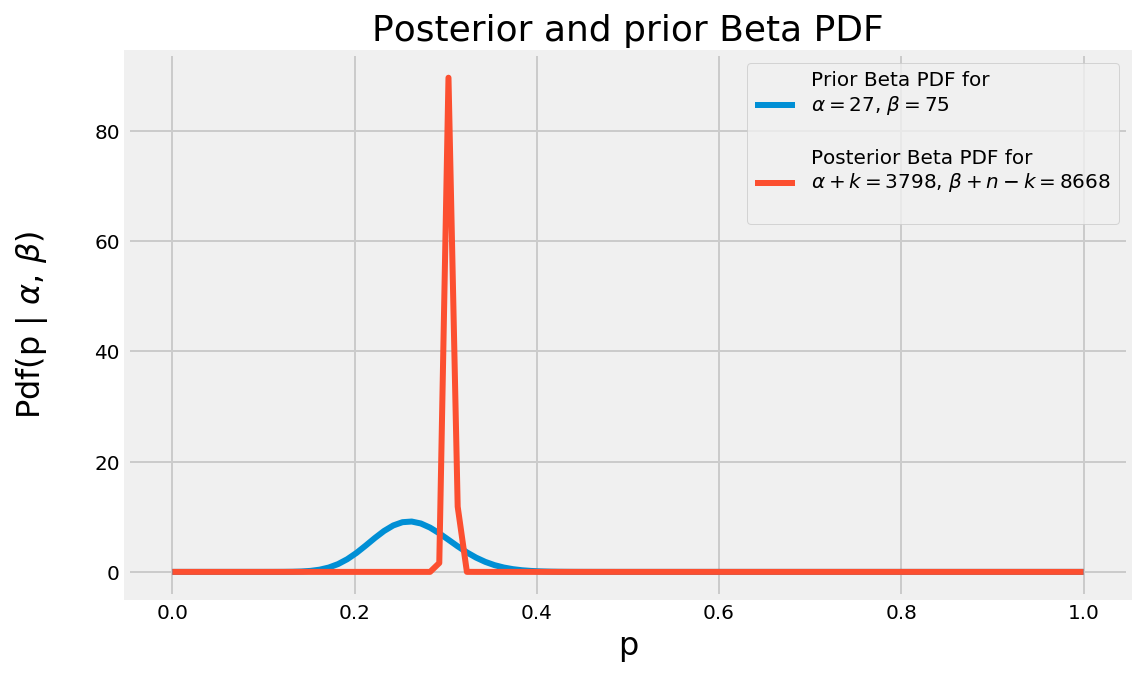

In [30]:
alpha = 27
beta = 75
n = 12364
k = 3771
prior_posterior_plot(n, k, alpha, beta)
# 能看到，如果数据量越大，越可以精确的缩小概率分布的范围。不像下图一样范围广泛。

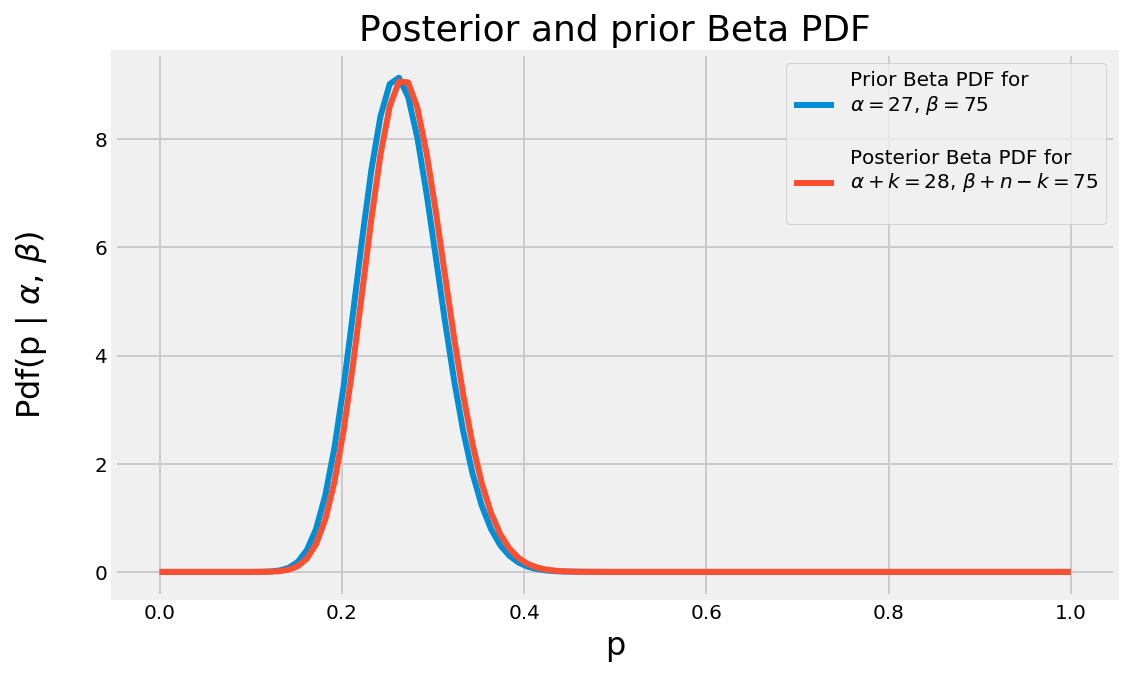

In [31]:
alpha = 27
beta = 75
n = 1
k = 1
prior_posterior_plot(n, k, alpha, beta)